In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
from matplotlib import pyplot as plt
import math
import cv2

Shape of Image (200, 200, 3)


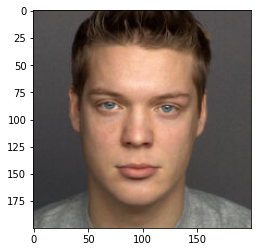

In [2]:
# Read Image 
img = cv2.imread('Images/Male_Image.jpeg')
img = img[:,:,::-1]

# Show Image 
plt.imshow(img)
print("Shape of Image",img.shape)

In [3]:
class SpectralPooling:
    
    def __init__(self):
        pass


    def tf_fouriertransform(self,spatial_image):
        '''
        Performs Fast Fourier Transform on the input image.
        Shifts DC Component of Fourier image to the Center
        
        Inputs: 
        1) Spatial image , Real value , dimensions [channels,length,width]
        
        Outputs: 
        1) Spectral image , Complex value Array , dimensions [channels,length,width]
        '''
        
        # Convert it into Fourier Transform
        fourier_image = tf.signal.fft2d(spatial_image)

        # DC should be shifted to Center 
        fourier_image = tf.signal.fftshift(fourier_image)

        return fourier_image
    
    def tf_inversefouriertransform(self,fourier_image):
        '''
        Shifts DC Component of Fourier image to the top. 
        
        Performs InverseFast Fourier Transform on the input image.
        
        Inputs: 
        1) Spectral image , Complex value Array , dimensions [channels,length,width]
        
        Outputs: 
        1) Spatial image , Real value , dimensions [channels,length,width]
        
        '''
        # Shift DC back 
        fourier_image = tf.signal.ifftshift(fourier_image)

        # Convert it back into Spatial Image
        spatial_image = tf.signal.ifft2d(fourier_image)
        
        return spatial_image

    
    def tf_normalizeimage(self,spatial_image): 
        '''
        Normalize Image data to values between [0..255]
        
        Inputs: 
        1) Spatial image [length,width,channels]
        
        Outputs: 
        1) Normalized Spatial image [length,width,channels]
        
        '''
        channel_max = tf.reduce_max(spatial_image, axis=(0, 1))
        channel_min = tf.reduce_min(spatial_image, axis=(0, 1))
        
        normalized_spatialimage = tf.divide(spatial_image - channel_min,channel_max - channel_min)
        
        return normalized_spatialimage
    
    def tf_lowpassfilter(self,fourier_image,pool_size=4):
        '''
        Builds Low Pass filter using Fourier_image size and pool_size for dimensionreduction
        
        Inputs: 
        
        1) Spectral image , Complex value Array , dimensions [channels,length,width]
        2) Pool Size 
        
        Outputs:
        
        1) Filtered image , Complex value Array , dimensions [channels,length,width]
        '''
        fourierimage_size = fourier_image.shape
        filter_shape = pool_size
        lowpass = np.ones(shape=fourierimage_size, dtype=np.float32)         
        
        distance_from_corner = math.floor((fourierimage_size[1] - (fourierimage_size[1]/filter_shape)) / 2)
        lowpass[:,:distance_from_corner,:] = 0
        lowpass[:,-distance_from_corner: ,:] = 0

        distance_from_corner = math.floor((fourierimage_size[2] - (fourierimage_size[2]/filter_shape)) / 2)

        lowpass[:,:,:distance_from_corner] = 0
        lowpass[:,:,-distance_from_corner:] = 0
        
        plt.imshow(lowpass[0,:,:])
        filtered_image = fourier_image * lowpass
        
        return filtered_image 
                                          
    def spectral_pool(self,spatial_image,pool_size=4): 
        assert pool_size > 0 , "Pool Size cannot be lesser than 1" # denominator can't be 0

        # Convert it into Channels First 
        spatial_imagechannelsfirst = tf.transpose(spatial_image,perm=[2,0,1])
        
        # Get Fourier Image 
        fourier_image = self.tf_fouriertransform(tf.cast(spatial_imagechannelsfirst, tf.complex64))
    
        # Apply low pass filter on Fourier Image 
        if pool_size > 1 : 
            filtered_fourier_image = self.tf_lowpassfilter(fourier_image,pool_size)
        else :
            filtered_fourier_image = fourier_image
        
        # Convert it back into spatial image 
        filtered_spatial_image= self.tf_inversefouriertransform(filtered_fourier_image)
        
        filtered_spatial_image_channelslast = tf.math.real(tf.transpose(filtered_spatial_image,perm=[1,2,0]))
        filtered_fourier_image = tf.transpose(filtered_fourier_image,perm=[1,2,0])
        
        filtered_spatial_image = self.tf_normalizeimage(filtered_spatial_image_channelslast)  
        magnitude_spectrum = 20*np.log(np.abs(filtered_fourier_image) + 1e-45)
        magnitude_spectrum = self.tf_normalizeimage(magnitude_spectrum)      
                                       
                                          
        return magnitude_spectrum,filtered_spatial_image

In [4]:
spectral_pooling = SpectralPooling()

In [5]:
plt.imshow(filtered_spatial_image)

NameError: name 'filtered_spatial_image' is not defined

In [ ]:
fig, axes = plt.subplots(3, 6, figsize=(20, 9), sharex=True, sharey=True)
pool_size = [64, 32, 16, 8, 4, 1]

for i in range(len(pool_size)):
    
    ax1 = axes[0,i]
    max_pool_2d = tf.keras.layers.MaxPooling2D(pool_size=pool_size[i])
    image = np.expand_dims(img,0)    
    reduced_image = max_pool_2d(image)

    ax1.imshow(reduced_image[0,:,:,:], interpolation='none')
    
    filtered_fourier_image,filtered_spatial_image = spectral_pooling.spectral_pool(img,pool_size=pool_size[i])
    ax1 = axes[1,i]
    ax1.imshow(filtered_spatial_image, interpolation='none')
    
    ax2 = axes[2,i]
    ax2.imshow(filtered_fourier_image, interpolation='none')
    ax2.set_xlabel(pool_size[i]**2)

In [ ]:
fig1 = plt.figure(figsize=(20, 9)) # create a figure with the default size 

im1 = np.random.rand(5,5)
print(im1.shape)
ax1 = fig1.add_subplot(2,2,1) 
ax1.imshow(im1, interpolation='none')
ax1.set_title('5 X 5')

im2 = np.random.rand(10,10)
print(im2.shape)
ax2 = fig1.add_subplot(2,2,2)
ax2.imshow(im2, interpolation='none')
ax2.set_title('10 X 10')
